## 1.实验环境

- 平台：华为启智平台调试任务
- 框架：MindSpore1.8.1
- 硬件NPU：Ascend 910

## 2.数据集

我们使用“中药炮制饮片”数据集，该数据集由成都中医药大学提供，共包含中药炮制饮片的 3 个品种，分别为：蒲黄、山楂、王不留行，每个品种又有着4种炮制状态：生品、不及适中、太过，每类包含 500 张图片共12类5000张图片，图片尺寸为 4K，图片格式为 jpg。
下面是数据集中的一些样例图片：

<img src="../7.案例中使用的图片/image-20230630102435999.png" alt="image-20230630102435999" style="zoom:67%;" />

## 3.模型介绍

我们使用Resnet50作为基础模型，模型由MindSpore框架编写，我们在此基础上进行了修改，将最后一层的输出改为12，以适应我们的数据集。
模型结构如下：

<img src="../7.案例中使用的图片/image-20230630095910087.png" alt="image-20230630095910087" style="zoom:80%;" />

## 4.可视化

我们对实验过程中的accuracy与batch_size的关系进行了可视化，如下图所示：

<img src="../7.案例中使用的图片/image-20230630094957.png" alt="image-3.png" style="zoom:80%;" />

## 5.优化器和损失函数

我们使用了Momentum优化器，其中参数momentum设为0.9，而损失函数使用SoftmaxCrossEntropyWithLogits。

## 6.模型训练和推理

请参考README.md文件第3部分进行模型训练和推理

## 7.参考文献
[1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

## ======================
## 下面请按照步骤和提示运行代码
## ======================

In [1]:
import mindspore as ms
from mindspore.dataset import GeneratorDataset
import mindspore.dataset.vision as vision
import mindspore.dataset.transforms as transforms
from mindspore import dtype as mstype
import os
from PIL import Image
import numpy as np
import random

## 数据预处理

In [2]:
# 下载数据集
from download import download
url = "https://open-data.obs.cn-south-222.ai.pcl.cn:443/attachment/7/0/7009e8dc-af94-4f50-afae-0a68fa7db3ee/zhongyiyao.zip?response-content-disposition=attachment%3B+filename%3D%22zhongyiyao.zip%22&AWSAccessKeyId=ZSCXA9TLRN1USYWIF7A5&Expires=1683365194&Signature=9%2BAinu6Pw%2Beh1PqZTyl5gbj4B3A%3D"
# 创建的是调试任务，url修改为数据集上传生成的url链接
if not os.path.exists("dataset"):
    download(url, "dataset", kind="zip")

In [3]:
# 问题：原图片为4k，显存会爆炸
# 这里将data_dir的数据resize到((1000,1000))后存入
# 同时也能将损坏的图片给过滤掉
data_dir = "dataset/zhongyiyao"
new_data_path = "dataset1/zhongyiyao"
if not os.path.exists(new_data_path):
    for path in ['train','test']:
        data_path = data_dir + "/" + path
        classes = os.listdir(data_path)
        for (i,class_name) in enumerate(classes):
            floder_path =  data_path+"/"+class_name
            print(floder_path)
            for image_name in os.listdir(floder_path):
                try:
                    image = Image.open(floder_path + "/" + image_name)
                    image = image.resize((1000,1000))
                    target_dir = new_data_path+"/"+path+"/"+class_name
                    if not os.path.exists(target_dir):
                        os.makedirs(target_dir)
                    if not os.path.exists(target_dir+"/"+image_name):
                        image.save(target_dir+"/"+image_name)
                except:
                    # print(floder_path + "/" + image_name)
                    pass
        

        

dataset/zhongyiyao/train/ph_sz
dataset/zhongyiyao/train/ph_sp
dataset/zhongyiyao/train/wblx_sz
dataset/zhongyiyao/train/sz_sp
dataset/zhongyiyao/train/sz_bj
dataset/zhongyiyao/train/wblx_sp
dataset/zhongyiyao/train/wblx_tg
dataset/zhongyiyao/train/ph_bj
dataset/zhongyiyao/train/sz_sz
dataset/zhongyiyao/train/wblx_bj
dataset/zhongyiyao/train/sz_tg
dataset/zhongyiyao/train/ph_tg
dataset/zhongyiyao/test/ph_sz
dataset/zhongyiyao/test/ph_sp
dataset/zhongyiyao/test/wblx_sz
dataset/zhongyiyao/test/sz_sp
dataset/zhongyiyao/test/sz_bj
dataset/zhongyiyao/test/wblx_sp
dataset/zhongyiyao/test/wblx_tg
dataset/zhongyiyao/test/ph_bj
dataset/zhongyiyao/test/sz_sz
dataset/zhongyiyao/test/wblx_bj
dataset/zhongyiyao/test/sz_tg
dataset/zhongyiyao/test/ph_tg


In [ ]:
# 问题：针对原数据集格式，对数据集进行划分

import numpy as np
from sklearn.model_selection import train_test_split
import shutil

def split_data(X, y, test_size=0.2, val_size=0.2, random_state=42):
    """
    This function splits the data into training, validation, and test sets.
    """
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size/(1-test_size), random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test


data_dir = "dataset1/zhongyiyao"
floders = os.listdir(data_dir)
target = ['train','test','valid']
if set(floders) == set(target):
    # 如果已经划分则跳过
    pass
elif 'train' in floders:
    # 如果已经划分了train，test，那么只需要从train里边划分出valid
    floders = os.listdir(data_dir)
    new_data_dir = os.path.join(data_dir,'train')
    classes = os.listdir(new_data_dir)
    if '.ipynb_checkpoints' in classes:
        classes.remove('.ipynb_checkpoints')
    print(classes)
    imgs = []
    labels = []
    for (i,class_name) in enumerate(classes):
        new_path =  new_data_dir+"/"+class_name
        for image_name in os.listdir(new_path):
            imgs.append(image_name)
            labels.append(class_name)
            # 直接保存image_name，和class_name（ph_bj）
    imgs_train,imgs_val,labels_train,labels_val = X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.2, random_state=42)
    print(len(imgs_train))
    print(len(imgs_val))
    # 将这些图片挪到对应文件夹下边
    target_data_dir = os.path.join(data_dir,'valid')
    if not os.path.exists(target_data_dir):
        os.mkdir(target_data_dir)
    for (img,label) in zip(imgs_val,labels_val):
        source_path = os.path.join(data_dir,'train',label)
        target_path = os.path.join(data_dir,'valid',label)
        if not os.path.exists(target_path):
            os.mkdir(target_path)
        source_img = os.path.join(source_path,img)
        target_img = os.path.join(target_path,img)
        print(f'move {source_img} to {target_img} success!')
        shutil.move(source_img,target_img)
        # break
else:
    # 直接从最开始进行划分
    phones = os.listdir(data_dir)
    imgs = []
    labels = []
    # 首先是手机型号
    for phone in phones:
        phone_data_dir = os.path.join(data_dir,phone)
        yaowu_list = os.listdir(phone_data_dir)
        # 列出药品品种
        for yaowu in yaowu_list:
            yaowu_data_dir = os.path.join(phone_data_dir,yaowu)
            # /zhongyiyao/iphone/蒲黄
            chengdu_list = os.listdir(yaowu_data_dir)
            for chengdu in chengdu_list:
                chengdu_data_dir = os.path.join(yaowu_data_dir,chengdu)
                # /zhongyiyao/iphone/蒲黄/不及
                for img in os.listdir(chengdu_data_dir):
                    # 遍历图片了
                    imgs.append(img)
                    # 添加名字
                    label = ' '.join([phone,yaowu,chengdu])
                    # label写的全一点可以定位到图片位置
                    labels.append(label)
    # 对图片进行划分
    imgs_train, imgs_val, imgs_test, labels_train, labels_val, labels_test = split_data(imgs, labels, test_size=0.2, val_size=0.2, random_state=42)
    img_label_tuple_list = [(imgs_train,labels_train),(imgs_val,labels_val),(imgs_test,labels_test)]
    # 将图片挪到对应位置
    for (i,split) in enumerate(spilits):
        # 遍历 train、valid、test
        target_data_dir = os.path.join(data_dir,split)
        # zhongyiyao/train
        if not os.path.exists(target_data_dir):
            os.mkdir(target_data_dir)
        imgs_list,labels_list = img_label_tuple_list[i]
        for (img,label) in zip(imgs_list,labels_list):
            label_split = label.split(' ')
            # [phone,yaowu,chengdu]
            source_img = os.path.join(data_dir,label_split[0],label_split[1],label_split[2],img)
            # /zhongyiyao/iphone/yaowu/chengdu/img
            target_img_dir = os.path.join(target_data_dir,label_split[1]+"_"+label_split[2])
            # /zhongyiyao/train/yaowu_chengdu
            if not os.path.exists(target_img_dir):
                os.mkdir(target_img_dir)
            target_img = os.path.join(target_img_dir,img)
            # /zhongyiyao/train/yaowu_chengdu/img
            shutil.move(source_img,target_img)
    

## 加载数据集

In [12]:
# 注意没有使用ImageFloder进行加载，原因是'.ipynb_checkpoints'缓存文件夹会被当作类文件夹进行识别，导致数据集加载错误
class Iterable:
    def __init__(self,data_path):
        self._data = []
        self._label = []
        self._error_list = []
        if data_path.endswith(('JPG','jpg','png','PNG')):
            # 用作推理，所以没有label
            image = Image.open(data_path)
            self._data.append(image)
            self._label.append(0)
        else:
            classes = os.listdir(data_path)
            # 问题：文件夹里会出现'.ipynb_checkpoints'文件夹，但是本身不显示
            if '.ipynb_checkpoints' in classes:
                classes.remove('.ipynb_checkpoints')
            print(classes)
            for (i,class_name) in enumerate(classes):
                # new_path = os.path.join(path,class_name)
                new_path =  data_path+"/"+class_name
                for image_name in os.listdir(new_path):
                    try:
                        image = Image.open(new_path + "/" + image_name)
                        self._data.append(image)
                        self._label.append(i)
                    except:
                        pass
                

    def __getitem__(self, index):
        return self._data[index], self._label[index]

    def __len__(self):
        return len(self._data)
    
    def get_error_list(self,):
        return self._error_list


In [13]:
# 加载dataloader
def create_dataset_zhongyao(dataset_dir,usage,resize,batch_size,workers):
    data = Iterable(dataset_dir)
    data_set = GeneratorDataset(data,column_names=['image','label'])
    trans = []
    if usage == "train":
        trans += [
            vision.RandomCrop(700, (4, 4, 4, 4)),
            # 这里随机裁剪尺度可以设置
            vision.RandomHorizontalFlip(prob=0.5)
        ]

    trans += [
        vision.Resize((resize,resize)),
        vision.Rescale(1.0 / 255.0, 0.0),
        vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        vision.HWC2CHW()
    ]

    target_trans = transforms.TypeCast(mstype.int32)
    # 数据映射操作
    data_set = data_set.map(
        operations=trans,
        input_columns='image',
        num_parallel_workers=workers)

    data_set = data_set.map(
        operations=target_trans,
        input_columns='label',
        num_parallel_workers=workers)

    # 批量操作
    data_set = data_set.batch(batch_size,drop_remainder=True)

    return data_set


In [16]:
# 加载dataloader
data_dir = "dataset1/zhongyiyao"
train_dir = data_dir+"/"+"train"
valid_dir = data_dir+"/"+"valid"
test_dir = data_dir+"/"+"test"
batch_size = 32 # 批量大小
image_size = 224 # 训练图像空间大小
workers = 4 # 并行线程个数
num_classes = 12 # 分类数量


# 设置随机种子，使得模型结果复现
seed = 42
ms.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

dataset_train = create_dataset_zhongyao(dataset_dir=train_dir,
                                       usage="train",
                                       resize=image_size,
                                       batch_size=batch_size,
                                       workers=workers)
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_zhongyao(dataset_dir=valid_dir,
                                     usage="valid",
                                     resize=image_size,
                                     batch_size=batch_size,
                                     workers=workers)
dataset_test = create_dataset_zhongyao(dataset_dir=test_dir,
                                     usage="test",
                                     resize=image_size,
                                     batch_size=batch_size,
                                     workers=workers)
step_size_val = dataset_val.get_dataset_size()
print(step_size_train)

['ph_sz', 'ph_sp', 'wblx_sz', 'sz_sp', 'sz_bj', 'wblx_sp', 'wblx_tg', 'ph_bj', 'sz_sz', 'wblx_bj', 'sz_tg', 'ph_tg']
['ph_sz', 'ph_sp', 'wblx_sz', 'sz_sp', 'sz_bj', 'wblx_sp', 'wblx_tg', 'ph_bj', 'sz_sz', 'wblx_bj', 'sz_tg', 'ph_tg']
['ph_sz', 'ph_sp', 'wblx_sz', 'sz_sp', 'sz_bj', 'wblx_sp', 'wblx_tg', 'ph_bj', 'sz_sz', 'wblx_bj', 'sz_tg', 'ph_tg']
137


In [8]:
print(f'训练集数据：{dataset_train.get_dataset_size()*batch_size}\n')
print(f'验证集数据：{dataset_val.get_dataset_size()*batch_size}\n')
print(f'测试集数据：{dataset_test.get_dataset_size()*batch_size}\n')

训练集数据：4384

验证集数据：1088

测试集数据：576



In [17]:
#index_label的映射
index_label_dict = {}
classes = os.listdir(train_dir)
if '.ipynb_checkpoints' in classes:
    classes.remove('.ipynb_checkpoints')
for i,label in enumerate(classes):
    index_label_dict[i] = label
index_label_dict

{0: 'ph_sz',
 1: 'ph_sp',
 2: 'wblx_sz',
 3: 'sz_sp',
 4: 'sz_bj',
 5: 'wblx_sp',
 6: 'wblx_tg',
 7: 'ph_bj',
 8: 'sz_sz',
 9: 'wblx_bj',
 10: 'sz_tg',
 11: 'ph_tg'}

In [10]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = next(dataset_val.create_dict_iterator())

images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()
print(f"Image shape: {images.shape}, Label: {labels}")


Image shape: (32, 3, 224, 224), Label: [ 5  7 11  7  8 11  4  8  1  5  2  7  4  0  1 10  1  4  3  6  2  6  3 10
  6  3  7  7  3  1  9  3]


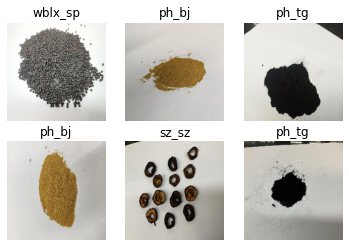

In [11]:
plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    image_trans = np.transpose(images[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image_trans = std * image_trans + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title(f"{index_label_dict[labels[i]]}")
    plt.imshow(image_trans)
    plt.axis("off")
plt.show()

## 定义网络

In [2]:
from mindspore import Model
from mindspore import context
import mindspore.ops as ops
from mindspore import Tensor, nn, set_context, GRAPH_MODE, train
from mindspore import load_checkpoint, load_param_into_net

In [3]:
# 方法2：直接定义resnet50网络
from typing import Type, Union, List, Optional
from mindspore import nn, train
from mindspore.common.initializer import Normal

In [4]:
# 直接定义resnet50网络模型
weight_init = Normal(mean=0, sigma=0.02)
gamma_init = Normal(mean=1, sigma=0.02)

class ResidualBlockBase(nn.Cell):
    expansion: int = 1  # 最后一个卷积核数量与第一个卷积核数量相等

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlockBase, self).__init__()
        if not norm:
            self.norm = nn.BatchNorm2d(out_channel)
        else:
            self.norm = norm

        self.conv1 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=3, stride=stride,
                               weight_init=weight_init)
        self.conv2 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=3, weight_init=weight_init)
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        """ResidualBlockBase construct."""
        identity = x  # shortcuts分支

        out = self.conv1(x)  # 主分支第一层：3*3卷积层
        out = self.norm(out)
        out = self.relu(out)
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.norm(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)
        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out


In [5]:
class ResidualBlock(nn.Cell):
    expansion = 4  # 最后一个卷积核的数量是第一个卷积核数量的4倍

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=1, weight_init=weight_init)
        self.norm1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel,
                               kernel_size=3, stride=stride,
                               weight_init=weight_init)
        self.norm2 = nn.BatchNorm2d(out_channel)
        self.conv3 = nn.Conv2d(out_channel, out_channel * self.expansion,
                               kernel_size=1, weight_init=weight_init)
        self.norm3 = nn.BatchNorm2d(out_channel * self.expansion)

        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):

        identity = x  # shortscuts分支

        out = self.conv1(x)  # 主分支第一层：1*1卷积层
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv3(out)  # 主分支第三层：1*1卷积层
        out = self.norm3(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)

        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out

In [6]:
def make_layer(last_out_channel, block: Type[Union[ResidualBlockBase, ResidualBlock]],
               channel: int, block_nums: int, stride: int = 1):
    down_sample = None  # shortcuts分支


    if stride != 1 or last_out_channel != channel * block.expansion:

        down_sample = nn.SequentialCell([
            nn.Conv2d(last_out_channel, channel * block.expansion,
                      kernel_size=1, stride=stride, weight_init=weight_init),
            nn.BatchNorm2d(channel * block.expansion, gamma_init=gamma_init)
        ])

    layers = []
    layers.append(block(last_out_channel, channel, stride=stride, down_sample=down_sample))

    in_channel = channel * block.expansion
    # 堆叠残差网络
    for _ in range(1, block_nums):

        layers.append(block(in_channel, channel))

    return nn.SequentialCell(layers)

In [7]:
from mindspore import load_checkpoint, load_param_into_net
from mindspore import ops


class ResNet(nn.Cell):
    def __init__(self, block: Type[Union[ResidualBlockBase, ResidualBlock]],
                 layer_nums: List[int], num_classes: int, input_channel: int) -> None:
        super(ResNet, self).__init__()

        self.relu = nn.ReLU()
        # 第一个卷积层，输入channel为3（彩色图像），输出channel为64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, weight_init=weight_init)
        self.norm = nn.BatchNorm2d(64)
        # 最大池化层，缩小图片的尺寸
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        # 各个残差网络结构块定义
        self.layer1 = make_layer(64, block, 64, layer_nums[0])
        self.layer2 = make_layer(64 * block.expansion, block, 128, layer_nums[1], stride=2)
        self.layer3 = make_layer(128 * block.expansion, block, 256, layer_nums[2], stride=2)
        self.layer4 = make_layer(256 * block.expansion, block, 512, layer_nums[3], stride=2)
        # 平均池化层
        self.avg_pool = ops.ReduceMean(keep_dims=True)
        # self.avg_pool = nn.AvgPool2d()
        
        # flattern层
        self.flatten = nn.Flatten()
        # 全连接层
        self.fc = nn.Dense(in_channels=input_channel, out_channels=num_classes)

    def construct(self, x):
        
        # print(x.shape)
        x = self.conv1(x)
        # print(x.shape)
        x = self.norm(x)
        x = self.relu(x)
        x = self.max_pool(x)
        # print(x.shape)

        x = self.layer1(x)
        # print(x.shape)
        x = self.layer2(x)
        # print(x.shape)
        x = self.layer3(x)
        # print(x.shape)
        x = self.layer4(x)
        # print(x.shape)

        x = self.avg_pool(x,(2,3))
        
        # print(x.shape)
        x = self.flatten(x)
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)

        return x

In [8]:
def _resnet(model_url: str, block: Type[Union[ResidualBlockBase, ResidualBlock]],
            layers: List[int], num_classes: int, pretrained: bool, pretrained_ckpt: str,
            input_channel: int):
    model = ResNet(block, layers, num_classes, input_channel)

    if pretrained:
        # 加载预训练模型
        download(url=model_url, path=pretrained_ckpt)
        param_dict = load_checkpoint(pretrained_ckpt)
        load_param_into_net(model, param_dict)

    return model


def resnet50(num_classes: int = 1000, pretrained: bool = False):
    resnet50_url = "https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/models/application/resnet50_224_new.ckpt"
    resnet50_ckpt = "./LoadPretrainedModel/resnet50_224_new.ckpt"
    return _resnet(resnet50_url, ResidualBlock, [3, 4, 6, 3], num_classes,
                   pretrained, resnet50_ckpt, 2048)


## 模型训练

In [10]:
# model = network
network = resnet50(pretrained=True)
num_class = 12
# 全连接层输入层的大小
in_channel = network.fc.in_channels
fc = nn.Dense(in_channels=in_channel, out_channels=num_class)
# 重置全连接层
network.fc = fc

for param in network.get_parameters():
    param.requires_grad = True


Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.


In [12]:
input_tensor = Tensor(np.ones([1, 3, 224, 224]).astype(np.float32))
ms.export(network, input_tensor, file_name='Resnet50', file_format='ONNX')

In [20]:
num_epochs = 50
# early stopping
patience = 5
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size_train * num_epochs,
                        step_per_epoch=step_size_train, decay_epoch=num_epochs)
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
model = ms.Model(network, loss_fn, opt, metrics={'acc'})

# 最佳模型存储路径
best_acc = 0
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/resnet50-best.ckpt"
# best_ckpt_path = "./BestCheckpoint/Googlenet-best.ckpt"

In [21]:
def train_loop(model, dataset, loss_fn, optimizer):
    # Define forward function
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss, logits

    # Get gradient function
    grad_fn = ms.ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

    # Define function of one-step training
    def train_step(data, label):
        (loss, _), grads = grad_fn(data, label)
        loss = ops.depend(loss, optimizer(grads))
        return loss

    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)

        if batch % 100 == 0 or batch == step_size_train - 1:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")

from sklearn.metrics import classification_report

def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    y_true = []
    y_pred = []
    for data, label in dataset.create_tuple_iterator():
        y_true.extend(label.asnumpy().tolist())
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        y_pred.extend(pred.argmax(1).asnumpy().tolist())
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    # print(y_true)
    # print(y_pred)
    print(classification_report(y_true,y_pred,target_names= list(index_label_dict.values()),digits=3))
    return correct,test_loss



def early_stopping(X, y, model, patience=5, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
    best_val_loss = np.inf
    no_improvement_count = 0
    best_weights = None

    for epoch in range(num_epochs):
        model.train()
        # training code here

        model.eval()
        with torch.no_grad():
            val_loss = 0
            # validation code here
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = model.state_dict()
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                if no_improvement_count >= patience:
                    print('Early stopping triggered. Restoring best weights...')
                    model.load_state_dict(best_weights)
                    break
    return model, X_train, y_train, X_val, y_val


In [22]:
no_improvement_count = 0
loss_list = []
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(network, dataset_train, loss_fn, opt)
    # acc = model.eval(dataset_val)['Accuracy']
    acc,loss = test_loop(network, dataset_val, loss_fn)
    loss_list.append(loss)
    if acc > best_acc:
        best_acc = acc
        if not os.path.exists(best_ckpt_dir):
            os.mkdir(best_ckpt_dir)
        ms.save_checkpoint(network, best_ckpt_path)
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count > patience:
            print('Early stopping triggered. Restoring best weights...')
            # model.load_state_dict(best_weights)
            break 
print("Done!")


Epoch 1
-------------------------------
loss: 2.482289  [  0/137]
loss: 0.335289  [100/137]
loss: 0.068987  [136/137]
Test: 
 Accuracy: 99.0%, Avg loss: 0.102014 

              precision    recall  f1-score   support

       ph_sz      1.000     0.978     0.989        93
       ph_sp      1.000     0.990     0.995        98
     wblx_sz      1.000     1.000     1.000        88
       sz_sp      0.946     1.000     0.972       106
       sz_bj      1.000     0.936     0.967        94
     wblx_sp      1.000     1.000     1.000        84
     wblx_tg      1.000     0.989     0.994        87
       ph_bj      0.988     1.000     0.994        82
       sz_sz      1.000     0.989     0.995        95
     wblx_bj      0.989     1.000     0.995        92
       sz_tg      0.987     1.000     0.994        78
       ph_tg      0.978     1.000     0.989        91

    accuracy                          0.990      1088
   macro avg      0.991     0.990     0.990      1088
weighted avg      0.990 

## 模型推理

In [23]:
import matplotlib.pyplot as plt

In [9]:
num_class = 12  # 
net = resnet50(num_class)
best_ckpt_path = 'BestCheckpoint/resnet50-best99.4.ckpt'
# 加载模型参数
param_dict = ms.load_checkpoint(best_ckpt_path)
ms.load_param_into_net(net, param_dict)
model = ms.Model(net)
image_size = 224
workers = 1

In [10]:
def predict_one(input_img):
    # 加载验证集的数据进行验证
    dataset_one = create_dataset_zhongyao(dataset_dir=input_img,
                                       usage="test",
                                       resize=image_size,
                                       batch_size=1,
                                       workers=workers)
    data = next(dataset_one.create_tuple_iterator())
    # print(data)
    images = data[0].asnumpy()
    labels = data[1].asnumpy()
    # 预测图像类别
    output = model.predict(ms.Tensor(data[0]))
    pred = np.argmax(output.asnumpy(), axis=1)
    # print(f'预测结果：{index_label_dict[pred[0]]}')
    return index_label_dict[pred[0]]

In [18]:
input_img = "dataset1/zhongyiyao/train/sz_tg/IMG_20230220_110101_11.JPG"
print(predict_one(input_img))

sz_tg


In [20]:
input_tensor = Tensor(np.ones([1, 3, 224, 224]).astype(np.float32))
ms.export(net, input_tensor, file_name='Resnet50_Ai', file_format='AIR')

In [27]:
def visualize_model(dataset_test):
    # 加载验证集的数据进行验证
    data = next(dataset_test.create_tuple_iterator())
    # print(data)
    images = data[0].asnumpy()
    labels = data[1].asnumpy()
    # 预测图像类别
    output = model.predict(ms.Tensor(data[0]))
    pred = np.argmax(output.asnumpy(), axis=1)

    # 显示图像及图像的预测值
    plt.figure(figsize=(10, 6))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title('predict:{}  actual:{}'.format(index_label_dict[pred[i]],index_label_dict[labels[i]]), color=color)
        picture_show = np.transpose(images[i], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()


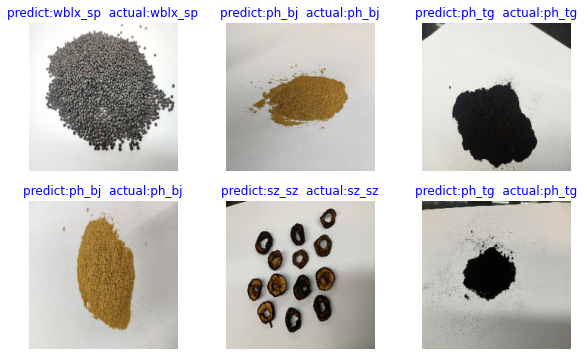

In [28]:
visualize_model(dataset_val)